In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from combat.pycombat import pycombat
from scipy import stats
import statsmodels.stats.multitest as smm
import joblib
import networkx as nx
from matplotlib import cm
import seaborn as sns

dataset = pd.read_csv('../../Dataset/Merged/MergedDataset.csv', index_col=0)
datasetID = dataset['SampleID'].apply(lambda x: x.split('-')[0]).values
labels = dataset['Label']
dataset = dataset.drop(columns=['SampleID', 'Label'])

data = pycombat(dataset.transpose(), datasetID).transpose()
data['Label'] = labels

Found 7 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


In [3]:
print(data)

       SEC14L1     YIPF5    SLC1A5        C2      NOL6      TPM3    PSMD11  \
0     8.196784  7.331882  7.490453  5.134335  7.086093  6.575738  8.394630   
1     8.527628  7.344338  7.138261  5.179817  7.057190  6.510802  8.436275   
2     8.861115  7.385836  7.151080  5.327242  7.054991  7.116553  8.261701   
3     8.369868  7.670419  7.065264  4.889047  7.046944  6.677731  8.372858   
4     8.673693  7.488290  7.195899  5.399563  7.019457  6.447549  8.497332   
...        ...       ...       ...       ...       ...       ...       ...   
2108  8.065088  7.492929  7.253305  4.953809  6.875882  6.897800  8.369420   
2109  9.252726  7.403881  7.339120  5.341230  6.822715  7.212214  8.349980   
2110  7.391173  7.499315  7.138937  4.837130  6.805491  6.805091  8.357332   
2111  9.246215  7.409623  7.443051  5.488207  6.889405  7.179457  8.377533   
2112  7.627567  7.483506  7.174680  4.749858  6.797381  6.893837  8.368402   

          FEZ1    ZNF33B     PTPRK  ...     GDPD5      RERE    

T-test

In [2]:
no_ms = data[data['Label'] == 0].drop(columns='Label')
ms = data[data['Label'] == 1].drop(columns='Label')

p_values = []
genes = ms.columns

for gene in genes:
    t_stat, p_val = stats.ttest_ind(no_ms[gene], ms[gene], equal_var=False)
    p_values.append(p_val)

# Correzione di Bonferroni
_, pvals_corrected, _, _ = smm.multipletests(p_values, alpha=0.05, method='bonferroni')

results = pd.DataFrame({
    'gene': genes,
    'p_value': p_values,
    'p_value_corrected': pvals_corrected
})

differentially_expressed_genes = results[results['p_value_corrected'] < 0.05]

print(differentially_expressed_genes)
print(differentially_expressed_genes['gene'].values)

        gene       p_value  p_value_corrected
98     THADA  6.220926e-14       3.474387e-10
171    DDX42  7.991485e-06       4.463244e-02
315     GIT2  1.009243e-42       5.636624e-39
538    BLCAP  1.804981e-07       1.008082e-03
1509  TXNRD1  6.490260e-13       3.624810e-09
1533  EEF1A1  6.078414e-12       3.394794e-08
1560    RPL4  7.862541e-17       4.391229e-13
1703   SRP72  1.628172e-12       9.093338e-09
1830   HUWE1  5.763045e-09       3.218660e-05
2117    ATF2  3.345339e-08       1.868372e-04
2138   TAPT1  5.546015e-12       3.097449e-08
2158  EIF4G2  3.564254e-30       1.990636e-26
2197    PMS1  8.265939e-07       4.616527e-03
2226  TUBA1B  6.736854e-12       3.762533e-08
2248    MTA2  3.589141e-06       2.004535e-02
2314   FBLN2  4.170735e-06       2.329355e-02
2352   KPNA4  1.301983e-07       7.271577e-04
2494    TIA1  2.563247e-09       1.431574e-05
2667   USP25  1.605142e-07       8.964717e-04
2705   TMED5  3.593168e-20       2.006785e-16
2909   CCNT1  2.627195e-06       1

In [3]:
expl_summary = joblib.load('../../ShapValues/DatasetFull/ensemble_summary.pkl')
ensemble_ablation = joblib.load("../../ShapValues/DatasetFull/ensembleSoft_ablationScores.pkl")
ensemble_featureSelected = joblib.load('../../ShapValues/DatasetFull/ensemble_featureSelected.pkl')

Intersezione con migliori 100 LIME explanations

In [4]:
expl_best = list(dict(sorted(dict(zip(data.columns, expl_summary)).items(), key=lambda item: item[1], reverse=True)).keys())[:100]
resultExpl = set(differentially_expressed_genes['gene']).intersection(set(expl_best))
print(resultExpl)

{'GIT2', 'EIF4G2', 'LITAF', 'AKAP13', 'FBLN2', 'CCNT1', 'TMED5', 'EEF1A1', 'USP25', 'TUBA1B'}


Intersezione con migliori 100 SHAP ensemble ridotto

In [5]:
shap_object = joblib.load('../../ShapValues/DatasetFull/ensembleSelected_shapValues.pkl')
ensembleSelected = joblib.load('../../Modelli/DatasetFull/ensembleSelected.pkl')
shap_values = shap_object.values
shap_importance = np.abs(shap_values).mean(0)
shap_dict = dict(zip(ensembleSelected.feature_names_in_, shap_importance))
expl_dictSummary = dict(zip(ensembleSelected.feature_names_in_, shap_importance))
expl_sorted = dict(sorted(expl_dictSummary.items(), key=lambda item: item[1], reverse=True))

print(set(differentially_expressed_genes['gene']).intersection(set(list(expl_sorted.keys())[:100])))

{'RPL4', 'GIT2', 'EIF4G2', 'AKAP13', 'FBLN2', 'CCNT1', 'EEF1A1', 'USP25', 'TXNRD1'}


Intersezione con feature ablation

In [6]:
ensemble_sorted_scores = dict(sorted(ensemble_ablation.items(), key=lambda item: item[1], reverse=True))
ensemble_bestFeatures = list({key: value for key, value in ensemble_sorted_scores.items() if value > 1.0}.keys())
resultAbl = set(differentially_expressed_genes['gene']).intersection(set(ensemble_bestFeatures))
print(resultAbl)

{'FBLN2', 'USP25', 'CCNT1', 'GIT2'}


In [ ]:
data.drop(['Label'], inplace=True, axis=1)

Risultati del test statistico eseguito con limma

In [15]:
geneR = ["GIT2", "EIF4G2", "AKAP13", "TMED5", "RPL4", "THADA", "SRP72", "TXNRD1", "TAPT1", "EEF1A1", "TUBA1B", "RFTN1", "TIA1", "HUWE1", "PKN2", "USP25", "POLH", "ATF2", "TERF2", "PIK3C3", "LITAF", "PMS1", "BLCAP", "KPNA4", "CCNT1", "ARID1A", "DDX3X", "DDX42", "FBLN2", "MTA2", "CDKAL1", "CBLB", "CAND1", "SLC4A7", "ELMO2", "DOCK2", "MTMR12", "HEATR1", "UBR2", "SOS1", "UBA52", "SSR4", "C5orf22", "ZNHIT1", "TNPO1", "VPS13D", "DDX17", "RAPGEF1", "PIGK", "KCTD20", "CAST", "MEF2C", "MACF1", "PTPN11", "ABI1", "BTRC", "SPIN1", "PRKAA1", "RAP2A", "MFAP3", "COPA", "REST", "EIF4A2", "ADM", "JAK1", "UCHL5", "ZBTB33", "HPRT1", "TOR1AIP1", "MFN2", "GPR132", "VDAC3", "TTLL5", "ANKFY1", "ABR", "RBL1", "PRKD3", "FH", "CNOT1", "CTNNB1", "CBFA2T2", "ATF7IP", "ITGA4", "PTCD2", "CSNK2A2", "TAOK1", "PAPOLG", "KRAS", "IKZF3", "PDK1", "ELMO3", "TF", "VCL"]

Geni in comune ai migliori trovati con expl

In [20]:
intersectionExpl = set(expl_best).intersection(set(geneR))
print(intersectionExpl)

{'USP25', 'AKAP13', 'EEF1A1', 'CCNT1', 'GIT2', 'FBLN2', 'EIF4G2'}


Geni in comune a quelli trovati con ablation

In [21]:
intersectionAblation = set(ensemble_bestFeatures).intersection(set(geneR))
print(intersectionAblation)

{'TUBA1B', 'C5orf22', 'EEF1A1', 'GPR132', 'CCNT1', 'EIF4G2', 'RFTN1'}


<h1>Rete di interazione</h1>
La rete è costruita considerando come geni quelli differenzialmente espressi e come relazioni le correlazioni lineari tra essere calcolate sul dataset

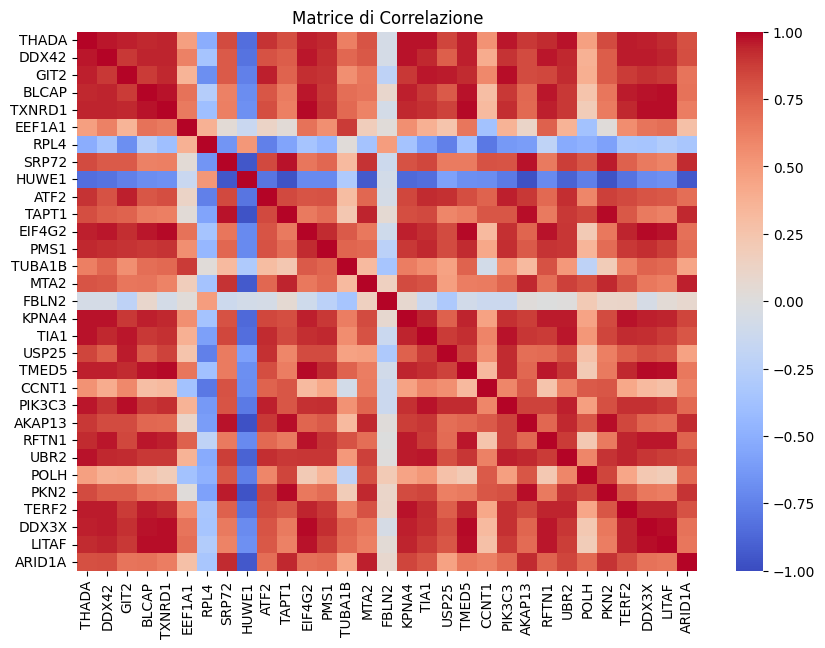

In [5]:
intersectCorr = dataset[differentially_expressed_genes['gene']].corr()

plt.figure(figsize=(10,7))
sns.heatmap(intersectCorr, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matrice di Correlazione')
plt.show()

In [6]:
ensemble_correlated_pairs = np.where(np.abs(intersectCorr) >= 0.75)

# Print the correlated pairs
for i, j in zip(ensemble_correlated_pairs[0], ensemble_correlated_pairs[1]):
    if i != j:
        print(f"{intersectCorr.index[i]} - {intersectCorr.columns[j]}: {intersectCorr.iloc[i, j]}")

THADA - DDX42: 0.9654117080481373
THADA - GIT2: 0.9509106985102596
THADA - BLCAP: 0.9330165655111996
THADA - TXNRD1: 0.9403624457390667
THADA - SRP72: 0.822751888471382
THADA - HUWE1: -0.8435164220032417
THADA - ATF2: 0.903573100183854
THADA - TAPT1: 0.8178058471043667
THADA - EIF4G2: 0.9500984949698613
THADA - PMS1: 0.9326428467270917
THADA - MTA2: 0.7963605285658126
THADA - KPNA4: 0.9699689941682093
THADA - TIA1: 0.9759953282565054
THADA - USP25: 0.845382310064192
THADA - TMED5: 0.9483718327463047
THADA - PIK3C3: 0.9644843619611801
THADA - AKAP13: 0.8849878928014846
THADA - RFTN1: 0.9266241019630747
THADA - UBR2: 0.9743705357393131
THADA - PKN2: 0.8277062042150657
THADA - TERF2: 0.9554258852172192
THADA - DDX3X: 0.9469725556531756
THADA - LITAF: 0.9242951940599438
THADA - ARID1A: 0.8082257280872597
DDX42 - THADA: 0.9654117080481373
DDX42 - GIT2: 0.8905459008261667
DDX42 - BLCAP: 0.941008086548389
DDX42 - TXNRD1: 0.941377893560155
DDX42 - SRP72: 0.7667978769031379
DDX42 - HUWE1: -0.81

C:\Users\samue\AppData\Local\Temp\ipykernel_23460\109444638.py:30: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Coefficiente di Correlazione")


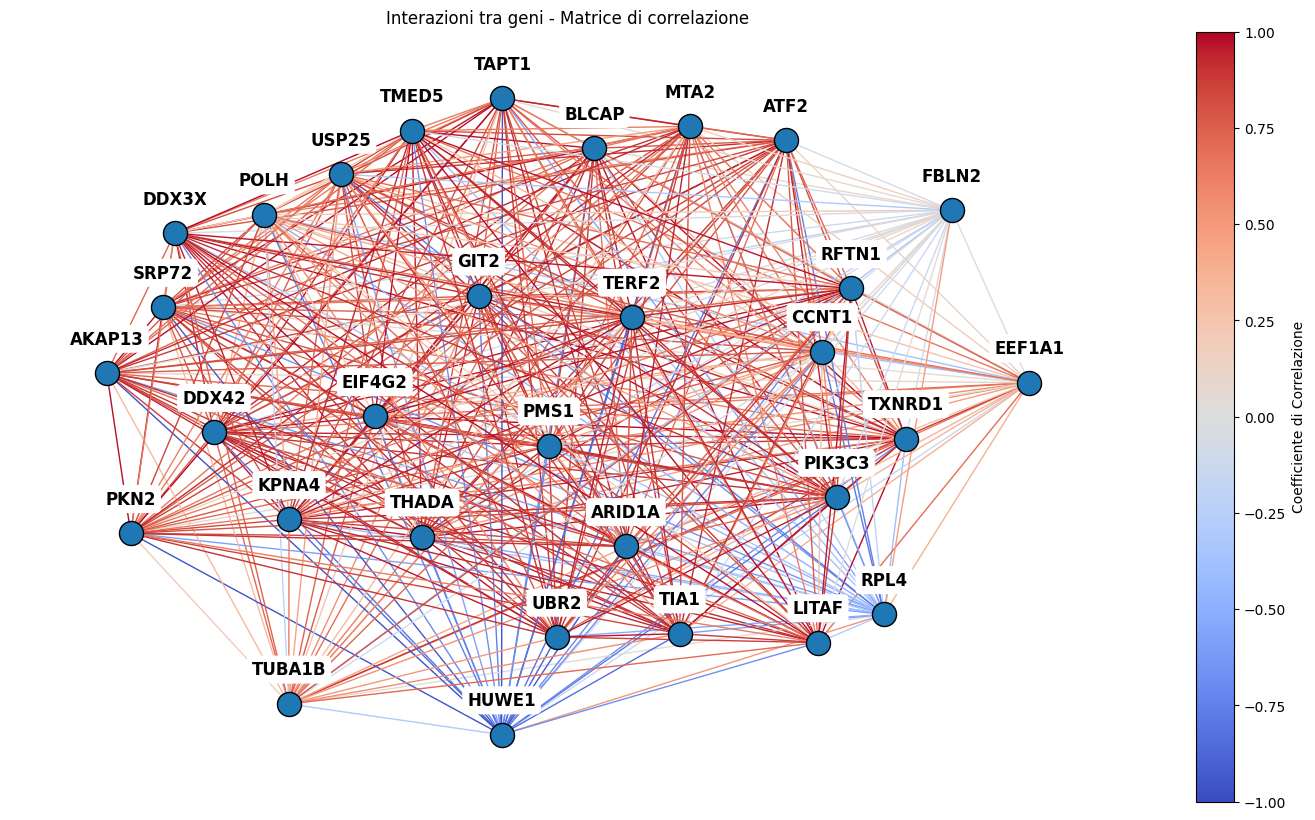

In [7]:
G = nx.Graph()

for i in range(intersectCorr.shape[0]):
    for j in range(intersectCorr.shape[1]):
        if i != j:
            G.add_edge(intersectCorr.columns[i], intersectCorr.columns[j], weight = intersectCorr.iloc[i, j])

weights = nx.get_edge_attributes(G, 'weight').values()
norm = plt.Normalize(-1, 1)
colors = [cm.coolwarm(norm(w)) for w in weights]

pos = nx.spring_layout(G, k=3)
fig, ax = plt.subplots(figsize=(18,10))

# Disegna i nodi con il contorno nero
nx.draw_networkx_nodes(G, pos, node_size=300, edgecolors='black', linewidths=1)

# Crea un offset per spostare le etichette sopra i nodi
label_pos = {node: (pos[node][0], pos[node][1] + 0.1) for node in G.nodes()}

# Disegna le etichette sopra i nodi
nx.draw_networkx_labels(G, label_pos, font_color='black', font_size=12, font_weight='bold', ax=ax, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))

# Disegna gli archi
nx.draw_networkx_edges(G, pos, ax=ax, edge_color=colors)

# Aggiungi la barra dei colori
sm = plt.cm.ScalarMappable(cmap=cm.coolwarm, norm=norm)
sm.set_array([])
plt.colorbar(sm, label="Coefficiente di Correlazione")
plt.title('Interazioni tra geni - Matrice di correlazione')
plt.axis('off')
plt.show()